In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import AutoModel, AutoTokenizer, BertForMaskedLM
from sklearn.preprocessing import LabelEncoder
from pytorch_lightning.callbacks.early_stopping import EarlyStopping 
from pytorch_lightning.callbacks import ModelCheckpoint
#%config InlineBackend.figure_format='retina'
torch.manual_seed(20)
import random
random.seed(10)

/home/tanwa/ml/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-30 17:45:41.045073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 17:45:41.968384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-08-30 17:45:41.968508: W tensorflow/compiler/xla/stream_executor/platf

In [2]:
train_df = pd.read_csv('dataset/healthver_train.csv')
test_df = pd.read_csv('dataset/healthver_test.csv')
val_df = pd.read_csv('dataset/healthver_dev.csv')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

In [4]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:

          #batch = tuple(t.to(device) for t in batch)
          inputs = {
              'input_ids': batch['input_ids'].to(device),
              'attention_mask':batch['attention_mask'].to(device),
              #'labels': batch['label'].to(device)
          }
          label =  batch['label'].to(device)
          outputs = model(**inputs)
          #logits = outputs.logits
          predicted_labels = torch.argmax(outputs, dim=1)

          predictions.extend(predicted_labels.detach().cpu().numpy())
          true_labels.extend(label.detach().cpu().numpy())

    return predictions, true_labels, outputs

In [5]:
# Define the text classification dataset
from torch.utils.data import Dataset,DataLoader
class TextClassificationDataset(Dataset):
    def __init__(self, claims,evidences, labels, tokenizer, max_len_claim, max_len_evidence):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len_claim = max_len_claim
        self.max_len_evidence = max_len_evidence

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, index):
        claim = str(self.claims[index])
        evidence = str(self.evidences[index])
        label = self.labels[index]

        claim_encoding = self.tokenizer.encode_plus(
            claim,
            add_special_tokens=True,
            max_length=self.max_len_claim,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        evidence_encoding = self.tokenizer.encode_plus(
            evidence,
            add_special_tokens=True,
            max_length=self.max_len_evidence,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        claim_input_ids = claim_encoding['input_ids'].squeeze(0)  # Use squeeze(0) to remove the batch dimension
        claim_attention_mask = claim_encoding['attention_mask'].squeeze(0)

        evidence_input_ids = evidence_encoding['input_ids'].squeeze(0)  # Use squeeze(0) to remove the batch dimension
        evidence_attention_mask = evidence_encoding['attention_mask'].squeeze(0)
        #print(evidence_input_ids)
        # Concatenate the claims and evidences
       
        input_ids = torch.cat((evidence_input_ids, claim_input_ids), 0)
        attention_mask = torch.cat((evidence_attention_mask, claim_attention_mask), 0)
         # on printing the concatenated ids, it is found that th evidence input is added as the first encoding, claim comes after.
        # print(input_ids)
        # print(attention_mask)
        #label = torch.tensor(label, dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
class TextClassificationDatasetwithTopics(Dataset):
    def __init__(self, claims,evidences, labels, tokenizer, max_len_claim, max_len_evidence, topic_ips):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len_claim = max_len_claim
        self.max_len_evidence = max_len_evidence
        self.topics = topic_ips

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, index):
        claim = str(self.claims[index])
        evidence = str(self.evidences[index])
        topic = str(self.topics[index])
        label = self.labels[index]

        claim_encoding = self.tokenizer.encode_plus(
            claim,
            add_special_tokens=True,
            max_length=self.max_len_claim,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        evidence_encoding = self.tokenizer.encode_plus(
            evidence,
            add_special_tokens=True,
            max_length=self.max_len_evidence,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        topic_encoding = self.tokenizer.encode_plus(
          topic,
          add_special_tokens=True,
          max_length=1,
          padding='max_length',
          truncation=True,
          return_tensors='pt'
        )

        input_ids = torch.cat((claim_encoding['input_ids'].squeeze(), evidence_encoding['input_ids'].squeeze(), topic_encoding['input_ids'].squeeze()), 0)
        attention_mask = torch.cat((claim_encoding['attention_mask'].squeeze(), evidence_encoding['attention_mask'].squeeze(), topic_encoding['attention_mask'].squeeze()), 0)
        # print(input_ids)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [7]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

token_lengths_evidence = []
for evidence in train_df['evidence']:
  tokens = tokenizer.encode(evidence, max_length=512)
  token_lengths_evidence.append(len(tokens))
max_length_evidence = max(token_lengths_evidence)

token_lengths_claim = []
for claim in train_df['claim']:
  tokens = tokenizer.encode(claim, max_length=512)
  token_lengths_claim.append(len(tokens))
max_length_claim = max(token_lengths_claim)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [8]:
max_length_claim

136

In [9]:
max_length_evidence

181

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

class BERTClassifier(pl.LightningModule):
    def __init__(self, num_classes, dropout=0.1, learning_rate=1e-5):
        super(BERTClassifier, self).__init__()
        #self.tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")
        self.bert = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #print(outputs)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        #print(logits)
        return logits
        
    def training_step(self, batch, batch_idx):
        inputs, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
        logits = self(inputs, attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
        logits = self(inputs, attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=False)

    def test_step(self, batch, batch_idx):
        inputs, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
        logits = self.forward(inputs, attention_mask)
        preds = torch.argmax(logits, dim=1)
        #print(preds)
        return preds

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

# Version 01: Vanilla

This version is simple training and testing, without use of validation set, or use of any regularisation techniques. Topic ID is not used here either.

In [11]:
label_encoder = LabelEncoder()

train_claims = train_df['claim'].values
train_evidences = train_df['evidence'].values
train_labels = train_df['label'].values
train_topic_ips = train_df['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_df['claim'].values
val_evidences = val_df['evidence'].values
val_labels = val_df['label'].values
val_topic_ips = val_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)
target_names = list(label_encoder.classes_)

## Batch size 32

In [12]:
batch_size = 32

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [23]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_vanilla_model32')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-vanilla32-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
vanilla_model32 = BERTClassifier(3)
trainer.fit(vanilla_model32, train_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 2.3 K 
-----------------------------------------
109 M     Trainable params
0        

Epoch 0:   0%|                                                                                   | 0/83 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|█████████████████████████████████████████████████████| 83/83 [02:31<00:00,  1.82s/it, loss=0.789, v_num=1]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|███████████████████████████████████████████████████| 83/83 [02:32<00:00,  1.83s/it, loss=0.0659, v_num=1]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|███████████████████████████████████████████████████| 83/83 [02:32<00:00,  1.83s/it, loss=0.0659, v_num=1]


In [13]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
vanilla_best_model32 = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-vanilla32-epoch=13-train_loss=0.0520.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vanilla_best_model32.to(device) 
vanilla_train_predictions32, vanilla_train_labels32, _ = evaluate_model(vanilla_best_model32, train_data_loader)
vanilla_test_predictions32,vanilla_test_labels32, _ = evaluate_model(vanilla_best_model32, test_data_loader)

In [77]:
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

     Neutral       0.99      1.00      1.00      4397
     Refutes       1.00      0.98      0.99      2411
    Supports       0.99      1.00      0.99      3782

    accuracy                           0.99     10590
   macro avg       0.99      0.99      0.99     10590
weighted avg       0.99      0.99      0.99     10590


              precision    recall  f1-score   support

     Neutral       0.78      0.86      0.81       727
     Refutes       0.73      0.57      0.64       425
    Supports       0.74      0.76      0.75       671

    accuracy                           0.75      1823
   macro avg       0.75      0.73      0.74      1823
weighted avg       0.75      0.75      0.75      1823

[[4386    6    5]
 [  20 2364   27]
 [   8    4 3770]]

[[623  29  75]
 [ 78 243 104]
 [101  60 510]]


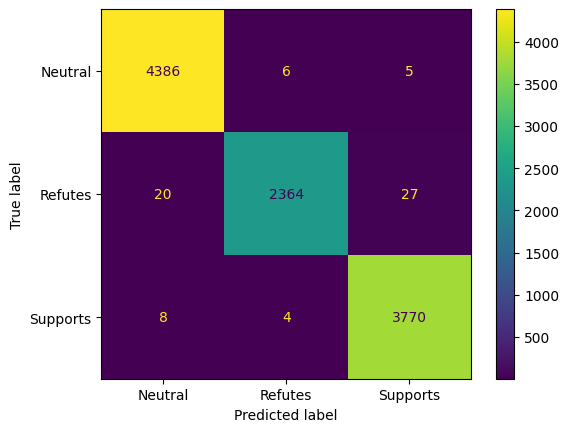

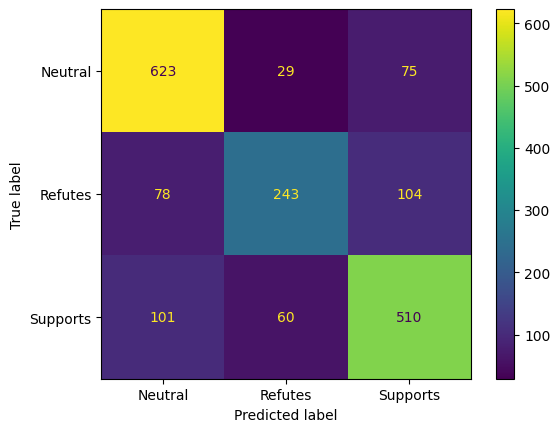

In [79]:
train_pred, train_true = vanilla_train_predictions32, vanilla_train_labels32
test_pred, test_true = vanilla_test_predictions32,vanilla_test_labels32
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

## Batch size 16

In [15]:
batch_size = 16

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [12]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_vanilla_model16')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-vanilla16-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
vanilla_model16 = BERTClassifier(3)
trainer.fit(vanilla_model16, train_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_vanilla_model16
Missing logger folder: ./logs/scibert_vanilla_model16
Missing logger folder: ./logs/scibert_vanilla_model16
Missing logger folder: ./logs/scibert_vanilla_model16
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
------------

Epoch 0:   0%|                                                                                  | 0/166 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 166/166 [02:36<00:00,  1.06it/s, loss=0.625, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 166/166 [02:36<00:00,  1.06it/s, loss=0.0225, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 166/166 [02:36<00:00,  1.06it/s, loss=0.0225, v_num=0]


In [16]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
vanilla_best_model16 = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-vanilla16-epoch=11-train_loss=0.0384.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vanilla_best_model16.to(device) 
vanilla_train_predictions16, vanilla_train_labels16, _ = evaluate_model(vanilla_best_model16, train_data_loader)
vanilla_test_predictions16,vanilla_test_labels16, _ = evaluate_model(vanilla_best_model16, test_data_loader)

              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00      4397
     Refutes       1.00      0.99      0.99      2411
    Supports       1.00      1.00      1.00      3782

    accuracy                           1.00     10590
   macro avg       1.00      1.00      1.00     10590
weighted avg       1.00      1.00      1.00     10590


              precision    recall  f1-score   support

     Neutral       0.79      0.85      0.82       727
     Refutes       0.72      0.59      0.65       425
    Supports       0.77      0.80      0.78       671

    accuracy                           0.77      1823
   macro avg       0.76      0.74      0.75      1823
weighted avg       0.76      0.77      0.76      1823

[[4388    6    3]
 [   5 2391   15]
 [   4    5 3773]]

[[615  36  76]
 [ 88 249  88]
 [ 76  61 534]]


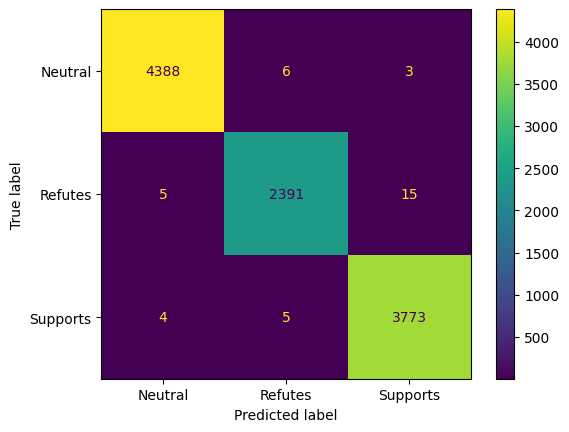

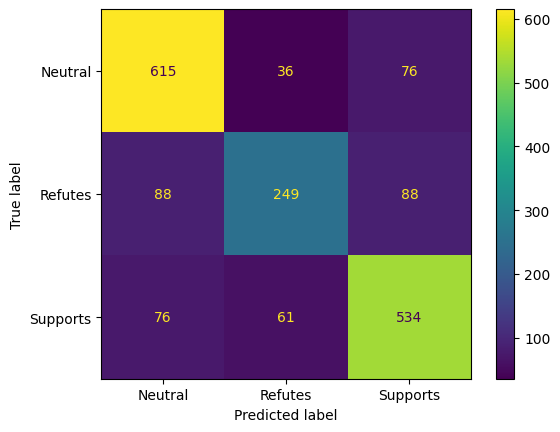

In [80]:
train_pred, train_true = vanilla_train_predictions16, vanilla_train_labels16
test_pred, test_true = vanilla_test_predictions16,vanilla_test_labels16
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

## Batch size 8

In [17]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [13]:


#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_vanilla_model8')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-vanilla8-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
vanilla_model8 = BERTClassifier(3)
trainer.fit(vanilla_model8, train_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_vanilla_model8
Missing logger folder: ./logs/scibert_vanilla_model8
Missing logger folder: ./logs/scibert_vanilla_model8
Missing logger folder: ./logs/scibert_vanilla_model8
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

Epoch 0:   0%|                                                                                  | 0/331 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 331/331 [02:57<00:00,  1.86it/s, loss=0.643, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 331/331 [02:57<00:00,  1.86it/s, loss=0.0285, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 331/331 [02:57<00:00,  1.86it/s, loss=0.0285, v_num=0]


In [19]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
vanilla_best_model8 = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-vanilla8-epoch=13-train_loss=0.0308.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vanilla_best_model8.to(device) 
vanilla_train_predictions8, vanilla_train_labels8, _ = evaluate_model(vanilla_best_model8, train_data_loader)
vanilla_test_predictions8,vanilla_test_labels8, _ = evaluate_model(vanilla_best_model8, test_data_loader)

              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00      4397
     Refutes       0.99      1.00      0.99      2411
    Supports       1.00      1.00      1.00      3782

    accuracy                           1.00     10590
   macro avg       1.00      1.00      1.00     10590
weighted avg       1.00      1.00      1.00     10590


              precision    recall  f1-score   support

     Neutral       0.80      0.84      0.82       727
     Refutes       0.73      0.61      0.67       425
    Supports       0.75      0.78      0.77       671

    accuracy                           0.77      1823
   macro avg       0.76      0.75      0.75      1823
weighted avg       0.76      0.77      0.76      1823

[[4384   10    3]
 [   4 2399    8]
 [   1    7 3774]]

[[614  30  83]
 [ 77 261  87]
 [ 81  68 522]]


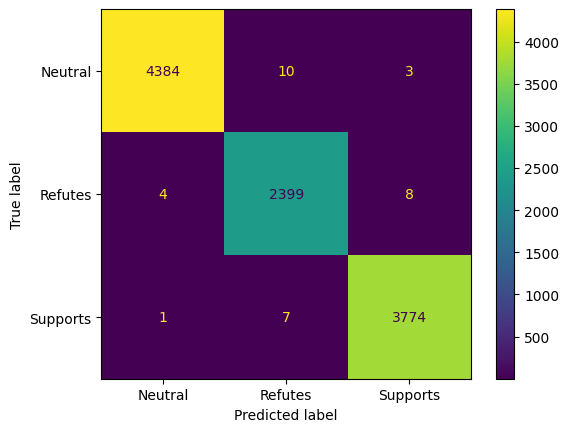

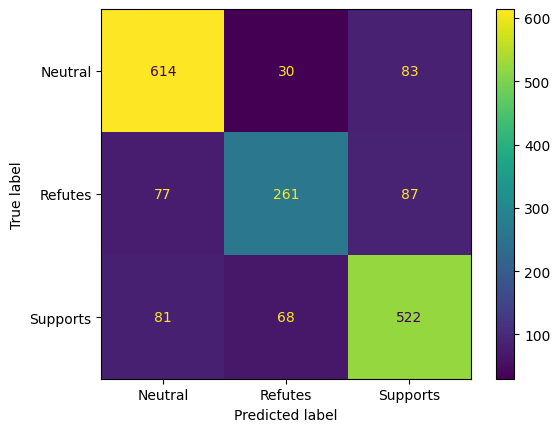

In [81]:
train_pred, train_true = vanilla_train_predictions8, vanilla_train_labels8
test_pred, test_true = vanilla_test_predictions8,vanilla_test_labels8
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# Batch size 4

In [21]:
batch_size = 4

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [14]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_vanilla_model4')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-vanilla4-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
vanilla_model4 = BERTClassifier(3)
trainer.fit(vanilla_model4, train_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_vanilla_model4
Missing logger folder: ./logs/scibert_vanilla_model4
Missing logger folder: ./logs/scibert_vanilla_model4
Missing logger folder: ./logs/scibert_vanilla_model4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
----------------

Epoch 0:   0%|                                                                                  | 0/662 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 662/662 [03:36<00:00,  3.06it/s, loss=0.515, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|██████████████████████████████████████████████████| 662/662 [03:35<00:00,  3.07it/s, loss=0.028, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████████████████████████████████████████████| 662/662 [03:40<00:00,  3.00it/s, loss=0.028, v_num=0]


In [22]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
vanilla_best_model4 = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-vanilla4-epoch=14-train_loss=0.0176.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vanilla_best_model4.to(device) 
vanilla_train_predictions4, vanilla_train_labels4, _ = evaluate_model(vanilla_best_model4, train_data_loader)
vanilla_test_predictions4,vanilla_test_labels4, _ = evaluate_model(vanilla_best_model4, test_data_loader)

              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00      4397
     Refutes       1.00      1.00      1.00      2411
    Supports       1.00      1.00      1.00      3782

    accuracy                           1.00     10590
   macro avg       1.00      1.00      1.00     10590
weighted avg       1.00      1.00      1.00     10590


              precision    recall  f1-score   support

     Neutral       0.76      0.87      0.81       727
     Refutes       0.74      0.61      0.67       425
    Supports       0.79      0.75      0.77       671

    accuracy                           0.76      1823
   macro avg       0.76      0.74      0.75      1823
weighted avg       0.76      0.76      0.76      1823

[[4393    3    1]
 [   7 2402    2]
 [   9    6 3767]]

[[631  27  69]
 [ 98 260  67]
 [104  66 501]]


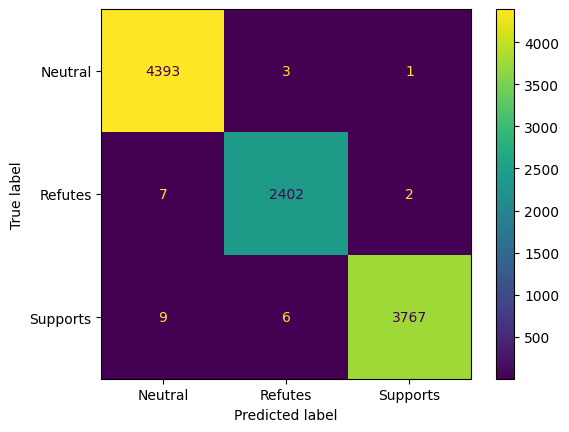

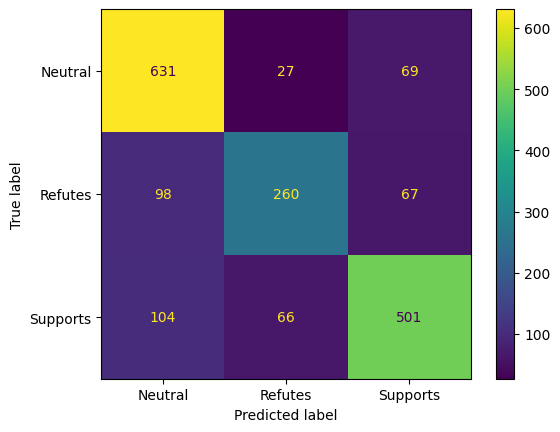

In [82]:
train_pred, train_true = vanilla_train_predictions4, vanilla_train_labels4
test_pred, test_true = vanilla_test_predictions4,vanilla_test_labels4
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# Regularised -  Patience, Earlystopping with Validation set

In [24]:
label_encoder = LabelEncoder()

train_claims = train_df['claim'].values
train_evidences = train_df['evidence'].values
train_labels = train_df['label'].values
train_topic_ips = train_df['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_df['claim'].values
val_evidences = val_df['evidence'].values
val_labels = val_df['label'].values
val_topic_ips = val_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)
target_names = list(label_encoder.classes_)

In [25]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [16]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_regularised_model')
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-regularised-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
regularised_model = BERTClassifier(3)
trainer.fit(regularised_model, train_data_loader, val_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_regularised_model
Missing logger folder: ./logs/scibert_regularised_model
Missing logger folder: ./logs/scibert_regularised_model
Missing logger folder: ./logs/scibert_regularised_model
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
----

Sanity Checking: 0it [00:00, ?it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:218: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  "strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks."


Sanity Checking DataLoader 0: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.01it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 0:   0%|                                                                                  | 0/391 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 391/391 [03:07<00:00,  2.09it/s, loss=0.616, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 3: 100%|████████████████████████████████████████████████████| 391/391 [03:07<00:00,  2.08it/s, loss=0.26, v_num=0]


In [26]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
regularised_best_model = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-regularised-epoch=00-val_loss=0.7136.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
regularised_best_model.to(device) 
regularised_train_predictions, regularised_vanilla_train_labels, _ = evaluate_model(regularised_best_model, train_data_loader)
regularised_vanilla_test_predictions, regularised_test_labels, _ = evaluate_model(regularised_best_model, test_data_loader)

In [86]:
target_names

['Neutral', 'Refutes', 'Supports']

              precision    recall  f1-score   support

     Neutral       0.92      0.87      0.90      4397
     Refutes       0.65      0.72      0.68      2411
    Supports       0.76      0.75      0.75      3782

    accuracy                           0.79     10590
   macro avg       0.78      0.78      0.78     10590
weighted avg       0.80      0.79      0.80     10590


              precision    recall  f1-score   support

     Neutral       0.76      0.75      0.75       727
     Refutes       0.50      0.54      0.52       425
    Supports       0.61      0.59      0.60       671

    accuracy                           0.64      1823
   macro avg       0.62      0.63      0.62      1823
weighted avg       0.64      0.64      0.64      1823

[[3840  221  336]
 [ 104 1737  570]
 [ 209  732 2841]]

[[544  63 120]
 [ 60 230 135]
 [113 164 394]]


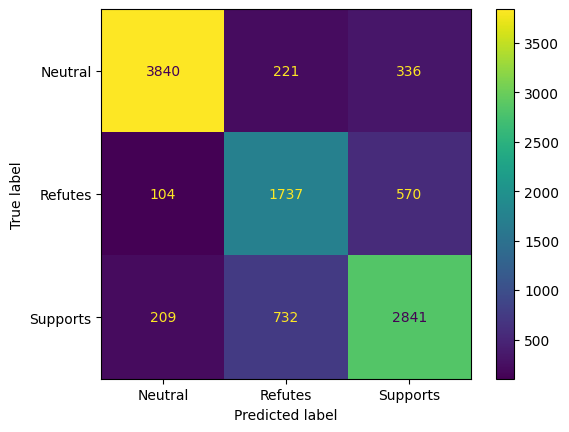

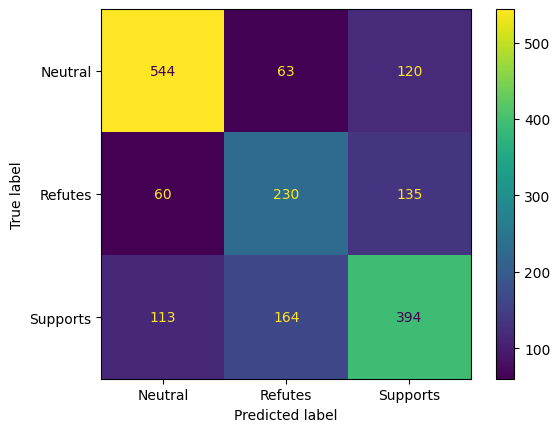

In [89]:
train_pred, train_true = regularised_train_predictions, regularised_vanilla_train_labels
test_pred, test_true = regularised_vanilla_test_predictions, regularised_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# Topic ID

In [12]:
label_encoder = LabelEncoder()

train_claims = train_df['claim'].values
train_evidences = train_df['evidence'].values
train_labels = train_df['label'].values
train_topic_ips = train_df['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_df['claim'].values
val_evidences = val_df['evidence'].values
val_labels = val_df['label'].values
val_topic_ips = val_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)

In [13]:
batch_size = 8

train_dataset = TextClassificationDatasetwithTopics(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence, train_topic_ips)
test_dataset = TextClassificationDatasetwithTopics(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence, test_topic_ips)
val_dataset = TextClassificationDatasetwithTopics(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence, val_topic_ips)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [22]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_topic_model')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-topic-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
topic_model = BERTClassifier(3)
trainer.fit(topic_model, train_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 2.3 K 
-----------------------------------------
109 M     Trainable params
0        

Epoch 0:   0%|                                                                                  | 0/331 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 331/331 [02:55<00:00,  1.89it/s, loss=0.592, v_num=1]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 331/331 [02:57<00:00,  1.86it/s, loss=0.0122, v_num=1]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 331/331 [02:57<00:00,  1.86it/s, loss=0.0122, v_num=1]


In [14]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
topic_best_model = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-topic-epoch=12-train_loss=0.0324.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
topic_best_model.to(device) 
topic_train_predictions, topic_train_labels, _ = evaluate_model(topic_best_model, train_data_loader)
topic_test_predictions,topic_test_labels, _ = evaluate_model(topic_best_model, test_data_loader)

              precision    recall  f1-score   support

     Neutral     0.9991    0.9993    0.9992      4397
     Refutes     0.9958    0.9925    0.9942      2411
    Supports     0.9955    0.9974    0.9964      3782

    accuracy                         0.9971     10590
   macro avg     0.9968    0.9964    0.9966     10590
weighted avg     0.9971    0.9971    0.9971     10590


              precision    recall  f1-score   support

     Neutral     0.8444    0.8363    0.8404       727
     Refutes     0.7129    0.6894    0.7010       425
    Supports     0.7659    0.7899    0.7777       671

    accuracy                         0.7850      1823
   macro avg     0.7744    0.7719    0.7730      1823
weighted avg     0.7849    0.7850    0.7848      1823

[[4394    2    1]
 [   2 2393   16]
 [   2    8 3772]]

[[608  40  79]
 [ 49 293  83]
 [ 63  78 530]]


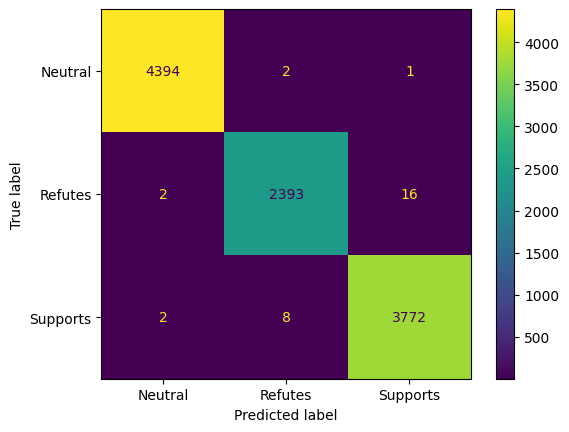

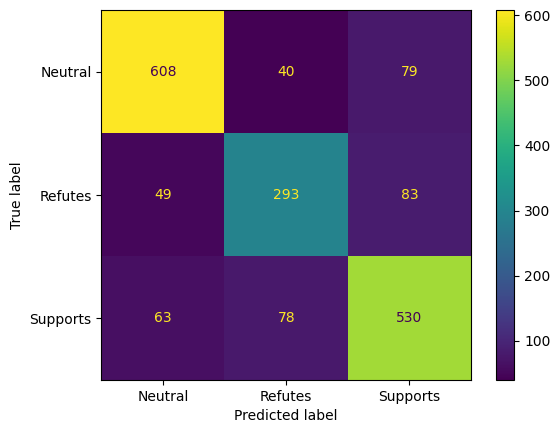

In [19]:
train_pred, train_true = topic_train_predictions, topic_train_labels
test_pred, test_true = topic_test_predictions,topic_test_labels
print(classification_report(train_true, train_pred, target_names = target_names, digits=4))
print()
print(classification_report(test_true, test_pred, target_names = target_names, digits=4))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# FOC

In [32]:
label_encoder = LabelEncoder()

train_claims = train_df['claim'].values
train_evidences = train_df['evidence'].values
train_labels = train_df['label'].values
train_topic_ips = train_df['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_df['claim'].values
val_evidences = val_df['evidence'].values
val_labels = val_df['label'].values
val_topic_ips = val_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)
target_names = list(label_encoder.classes_)

In [33]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import pytorch_lightning as pl

class BertClassifierFOC(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=2e-6, gamma=2.0):
        super(BertClassifierFOC, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
        self.bert_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        #self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert_model.config.hidden_size, num_classes)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
        logits = self.forward(input_ids, attention_mask)
        loss = self.focal_loss(logits, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
        logits = self.forward(input_ids, attention_mask)
        loss = self.focal_loss(logits, labels)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def focal_loss(self, logits, labels):
        ce_loss = self.criterion(logits, labels)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss


In [34]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

Monitored on validation set

In [16]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_foc_model')
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-foc-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

foc_model = BertClassifierFOC(num_classes=3)
# Train the model
trainer.fit(foc_model, train_data_loader, val_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type             | Params
------------------------------------------------
0 | bert_model | BertModel        | 109 M 
1 | classifier | Linear           | 2.3 K 
2 | criterion  | CrossEntropyLoss | 0     
-------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:218: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  "strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks."


Sanity Checking DataLoader 0: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 0:   0%|                                                                                  | 0/391 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 14: 100%|███████████████████████████████████████████████| 391/391 [03:08<00:00,  2.07it/s, loss=0.000746, v_num=2]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|███████████████████████████████████████████████| 391/391 [03:08<00:00,  2.07it/s, loss=0.000746, v_num=2]


In [35]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
foc_val_best_model = BertClassifierFOC.load_from_checkpoint('./Models/scibert_best_model-foc-epoch=00-val_loss=0.2061.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
foc_val_best_model.to(device) 
foc_val_train_predictions, foc_val_train_labels, _ = evaluate_model(foc_val_best_model, train_data_loader)
foc_val_test_predictions,foc_val_test_labels, _ = evaluate_model(foc_val_best_model, test_data_loader)

              precision    recall  f1-score   support

     Neutral       0.96      0.90      0.93      4397
     Refutes       0.74      0.80      0.77      2411
    Supports       0.83      0.84      0.83      3782

    accuracy                           0.86     10590
   macro avg       0.84      0.85      0.84     10590
weighted avg       0.86      0.86      0.86     10590


              precision    recall  f1-score   support

     Neutral       0.79      0.72      0.75       727
     Refutes       0.54      0.60      0.57       425
    Supports       0.67      0.68      0.68       671

    accuracy                           0.68      1823
   macro avg       0.66      0.67      0.67      1823
weighted avg       0.69      0.68      0.68      1823

[[3956  194  247]
 [  63 1924  424]
 [ 113  481 3188]]

[[527  82 118]
 [ 66 254 105]
 [ 78 137 456]]


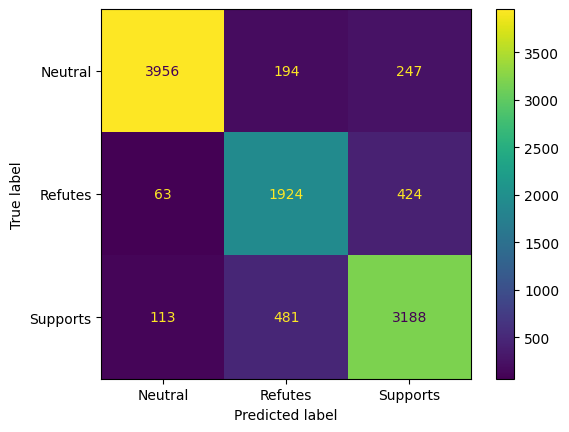

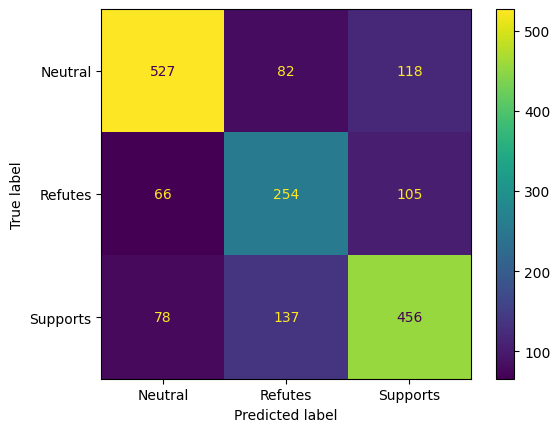

In [37]:
train_pred, train_true = foc_val_train_predictions, foc_val_train_labels
test_pred, test_true = foc_val_test_predictions,foc_val_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

In [31]:
# # for gamma=3 and lr = 2e-6
# train_pred, train_true = foc_train_predictions, foc_train_labels
# test_pred, test_true = foc_test_predictions,foc_test_labels
# print(classification_report(train_true, train_pred, target_names = target_names, digits=4))
# print()
# print(classification_report(test_true, test_pred, target_names = target_names, digits=4))
# print(confusion_matrix(train_true, train_pred))
# print()
# print(confusion_matrix(test_true, test_pred))

# ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
# ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

monitoring on training loss

In [38]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [14]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_foc_model_train')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-foc-gamma=3-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

foc_model_train = BertClassifierFOC(num_classes=3)
# Train the model
trainer.fit(foc_model_train, train_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type             | Params
------------------------------------------------
0 | bert_model | BertModel        | 109 M 
1 | classifier | Linear           | 2.3 K 
2 | criterion  | CrossEntropyLoss | 0     
-------------------------------------------

Epoch 0:   0%|                                                                                  | 0/331 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 14: 100%|████████████████████████████████████████████████| 331/331 [02:59<00:00,  1.84it/s, loss=0.00698, v_num=4]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████| 331/331 [02:59<00:00,  1.84it/s, loss=0.00698, v_num=4]


## Gamma = 2

In [39]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
foc_best_model = BertClassifierFOC.load_from_checkpoint('./Models/scibert_best_model-foc-epoch=06-train_loss=0.0003.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
foc_best_model.to(device) 
foc_train_predictions, foc_train_labels, _ = evaluate_model(foc_best_model, train_data_loader)
foc_test_predictions,foc_test_labels, _ = evaluate_model(foc_best_model, test_data_loader)

              precision    recall  f1-score   support

     Neutral       0.99      0.99      0.99      4397
     Refutes       0.98      0.97      0.97      2411
    Supports       0.98      0.99      0.99      3782

    accuracy                           0.99     10590
   macro avg       0.98      0.98      0.98     10590
weighted avg       0.99      0.99      0.99     10590


              precision    recall  f1-score   support

     Neutral       0.82      0.82      0.82       727
     Refutes       0.65      0.65      0.65       425
    Supports       0.74      0.75      0.74       671

    accuracy                           0.75      1823
   macro avg       0.74      0.74      0.74      1823
weighted avg       0.75      0.75      0.75      1823

[[4367   16   14]
 [  27 2337   47]
 [   9   41 3732]]

[[593  43  91]
 [ 67 276  82]
 [ 66 104 501]]


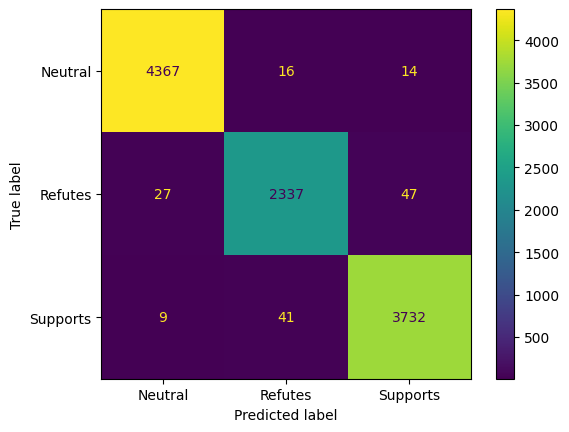

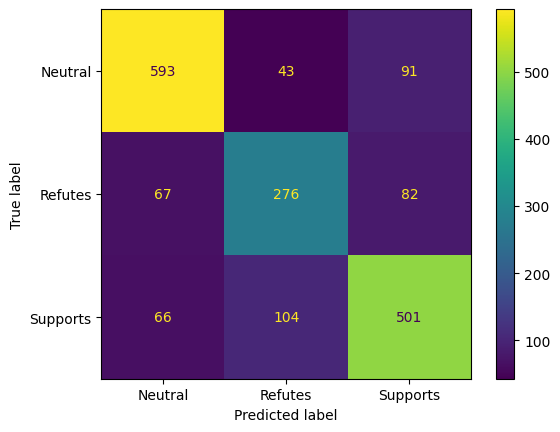

In [41]:
train_pred, train_true = foc_train_predictions, foc_train_labels
test_pred, test_true = foc_test_predictions,foc_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

## Gamma = 3

In [42]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
foc_best_model = BertClassifierFOC.load_from_checkpoint('./Models/scibert_best_model-foc-gamma=3-epoch=06-train_loss=0.0000.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
foc_best_model.to(device) 
foc_train_predictions, foc_train_labels, _ = evaluate_model(foc_best_model, train_data_loader)
foc_test_predictions,foc_test_labels, _ = evaluate_model(foc_best_model, test_data_loader)

              precision    recall  f1-score   support

     Neutral     0.9959    0.9829    0.9894      4397
     Refutes     0.9438    0.9743    0.9588      2411
    Supports     0.9761    0.9707    0.9734      3782

    accuracy                         0.9766     10590
   macro avg     0.9719    0.9760    0.9738     10590
weighted avg     0.9769    0.9766    0.9767     10590


              precision    recall  f1-score   support

     Neutral     0.8700    0.8006    0.8338       727
     Refutes     0.6828    0.7647    0.7214       425
    Supports     0.7729    0.7809    0.7769       671

    accuracy                         0.7850      1823
   macro avg     0.7752    0.7821    0.7774      1823
weighted avg     0.7906    0.7850    0.7867      1823

[[4322   35   40]
 [  12 2349   50]
 [   6  105 3671]]

[[582  46  99]
 [ 45 325  55]
 [ 42 105 524]]


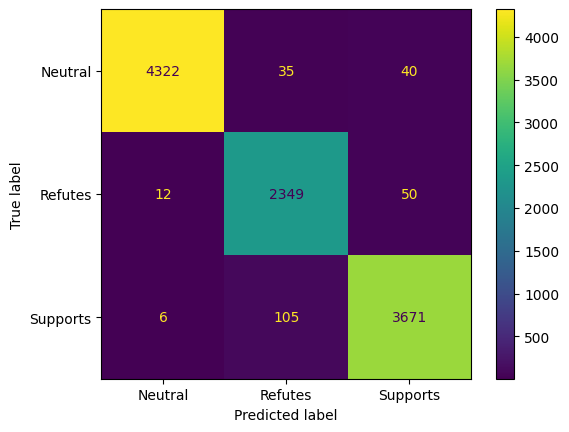

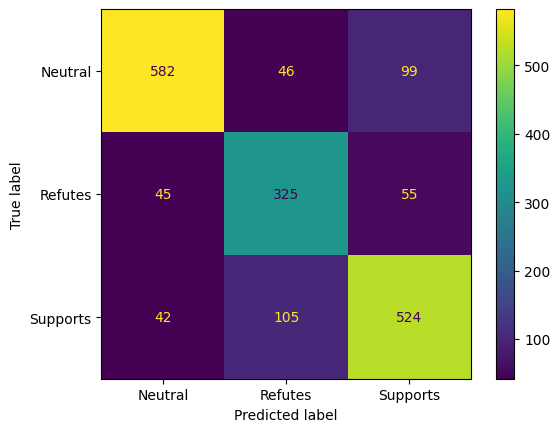

In [44]:
# for gamma=3 and lr = 2e-6
train_pred, train_true = foc_train_predictions, foc_train_labels
test_pred, test_true = foc_test_predictions,foc_test_labels
print(classification_report(train_true, train_pred, target_names = target_names, digits=4))
print()
print(classification_report(test_true, test_pred, target_names = target_names, digits=4))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# Topic + FOC

This variation is only for SciBERT

In [11]:
label_encoder = LabelEncoder()

train_claims = train_df['claim'].values
train_evidences = train_df['evidence'].values
train_labels = train_df['label'].values
train_topic_ips = train_df['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_df['claim'].values
val_evidences = val_df['evidence'].values
val_labels = val_df['label'].values
val_topic_ips = val_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)

In [12]:
batch_size = 8

train_dataset = TextClassificationDatasetwithTopics(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence, train_topic_ips)
test_dataset = TextClassificationDatasetwithTopics(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence, test_topic_ips)
val_dataset = TextClassificationDatasetwithTopics(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence, val_topic_ips)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [15]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_topicFOC_model')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-topicFOC-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
topicfoc_model = BertClassifierFOC(3, 2e-6, 3.0)
trainer.fit(topicfoc_model, train_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_topicFOC_model
Missing logger folder: ./logs/scibert_topicFOC_model
Missing logger folder: ./logs/scibert_topicFOC_model
Missing logger folder: ./logs/scibert_topicFOC_model
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type             | Params
---------

Epoch 0:   0%|                                                                                  | 0/331 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 14: 100%|████████████████████████████████████████████████| 331/331 [02:59<00:00,  1.85it/s, loss=0.00723, v_num=0]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████| 331/331 [03:01<00:00,  1.82it/s, loss=0.00723, v_num=0]


In [16]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
topicfoc_best_model = BertClassifierFOC.load_from_checkpoint('./Models/scibert_best_model-topicFOC-epoch=14-train_loss=0.0020.ckpt',num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
topicfoc_best_model.to(device) 
topicfoc_train_predictions, topicfoc_train_labels, _ = evaluate_model(topicfoc_best_model, train_data_loader)
topicfoc_test_predictions,topicfoc_test_labels, _ = evaluate_model(topicfoc_best_model, test_data_loader)

In [19]:
target_names = list(label_encoder.classes_)

              precision    recall  f1-score   support

     Neutral       0.98      0.98      0.98      4397
     Refutes       0.93      0.83      0.88      2411
    Supports       0.90      0.96      0.93      3782

    accuracy                           0.94     10590
   macro avg       0.94      0.92      0.93     10590
weighted avg       0.94      0.94      0.94     10590


              precision    recall  f1-score   support

     Neutral       0.82      0.85      0.84       727
     Refutes       0.65      0.53      0.58       425
    Supports       0.72      0.78      0.75       671

    accuracy                           0.75      1823
   macro avg       0.73      0.72      0.72      1823
weighted avg       0.74      0.75      0.74      1823

[[4323   36   38]
 [  57 1992  362]
 [  32  112 3638]]

[[617  44  66]
 [ 60 224 141]
 [ 73  76 522]]


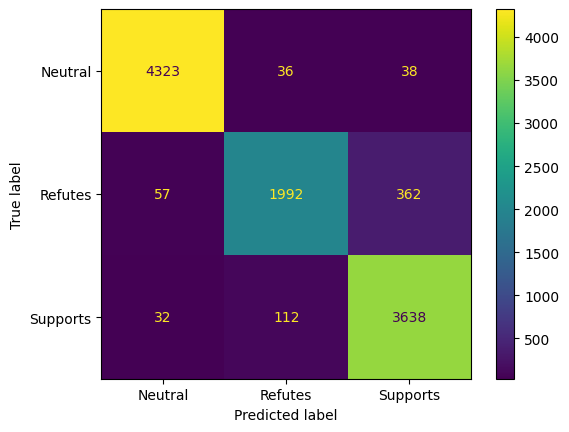

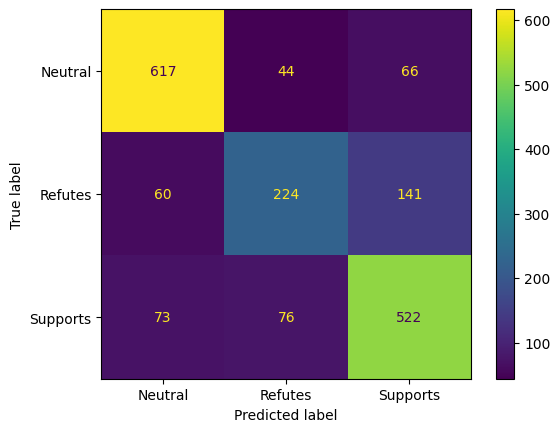

In [20]:
train_pred, train_true = topicfoc_train_predictions, topicfoc_train_labels
test_pred, test_true = topicfoc_test_predictions, topicfoc_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# Masked Data

In [40]:
train_masked_df = pd.read_csv('dataset/scibert_masked_augmented_train.csv')
val_masked_df = pd.read_csv('dataset/scibert_masked_augmented_val.csv')

In [41]:
test_df = pd.read_csv('dataset/healthver_test.csv')

In [42]:
label_encoder = LabelEncoder()

train_claims = train_masked_df['claim'].values
train_evidences = train_masked_df['evidence'].values
train_labels = train_masked_df['label'].values
train_topic_ips = train_masked_df['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_masked_df['claim'].values
val_evidences = val_masked_df['evidence'].values
val_labels = val_masked_df['label'].values
val_topic_ips = val_masked_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)
target_names = list(label_encoder.classes_)

In [30]:
train_masked_df

,id,evidence,claim,label,topic_ip,question
0,1693,social distancing and have seen slowing the sp...,"both in the U.S. and globally, that social dis...",Supports,10,has social distancing had an impact on slowing...
1,10386,The contaminated surface environment in hospit...,coronavirus can live on your clothes and shoes,Neutral,16,touching a contaminated surface will not make ...
2,10976,"Currently available published, peer-reviewed r...",As more companies begin clinical trials for a ...,Neutral,17,are there any clinical trials available for th...
3,10345,The objective of this study is to determine if...,Are there natural remedies that will prevent m...,Neutral,154,Are there natural remedies that will prevent m...
4,227,"Covid19 infection began in Wuhan (Hubei, China...","The novel coronavirus is a zoonotic disease, m...",Neutral,1,what is the origin of COVID-19
...,...,...,...,...,...,...
12996,9554,The dexamethasone was top-ranked in the predic...,Dexamethasone can not improve COVID-19 survival,Refutes,112,Is dexamethasone effective for treating COVID-19?
12997,6872,ferrets and cats are highly susceptible to SAR...,Felines are susceptible to coronaviruses in ge...,Supports,67,Can animals spread COVID-19?
12998,2492,Gustatory Dysfunction as an Early Symptom in C...,Early Symptoms Of COVID-19 Initial reports sta...,Neutral,26,what are the early symptoms of COVID-19?
12999,5346,"In late December 2019 in Wuhan, China, several...",Coronavirus disease 2019 (COVID-19): While gar...,Supports,52,Does garlic protect against covid-19


In [43]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [31]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_masked_model')
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-masked-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
     logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
masked_model = BERTClassifier(3)
trainer.fit(masked_model, train_data_loader, val_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 2.3 K 
-----------------------------------------
109 M     Trainable params
0        

Sanity Checking: 0it [00:00, ?it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:218: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  "strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks."


Sanity Checking DataLoader 0: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.18it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 0:   0%|                                                                                  | 0/480 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 480/480 [03:50<00:00,  2.08it/s, loss=0.501, v_num=1]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 480/480 [03:49<00:00,  2.10it/s, loss=0.0681, v_num=1]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 480/480 [03:49<00:00,  2.09it/s, loss=0.0681, v_num=1]


In [44]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
masked_best_val_model = BERTClassifier.load_from_checkpoint('Models/scibert_best_model-masked-epoch=00-val_loss=0.7977.ckpt' ,num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [95]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
masked_best_val_model.to(device) 
maskedval_train_predictions, maskedval_train_labels, _ = evaluate_model(masked_best_val_model, train_data_loader)
maskedval_test_predictions,maskedval_test_labels, _ = evaluate_model(masked_best_val_model, test_data_loader)

              precision    recall  f1-score   support

     Neutral       0.90      0.89      0.89      4397
     Refutes       0.86      0.82      0.84      4397
    Supports       0.79      0.84      0.81      4397

    accuracy                           0.85     13191
   macro avg       0.85      0.85      0.85     13191
weighted avg       0.85      0.85      0.85     13191


              precision    recall  f1-score   support

     Neutral       0.74      0.75      0.74       727
     Refutes       0.63      0.53      0.58       425
    Supports       0.66      0.70      0.68       671

    accuracy                           0.68      1823
   macro avg       0.67      0.66      0.67      1823
weighted avg       0.68      0.68      0.68      1823

[[3899  173  325]
 [ 148 3611  638]
 [ 302  413 3682]]

[[546  55 126]
 [ 76 227 122]
 [119  81 471]]


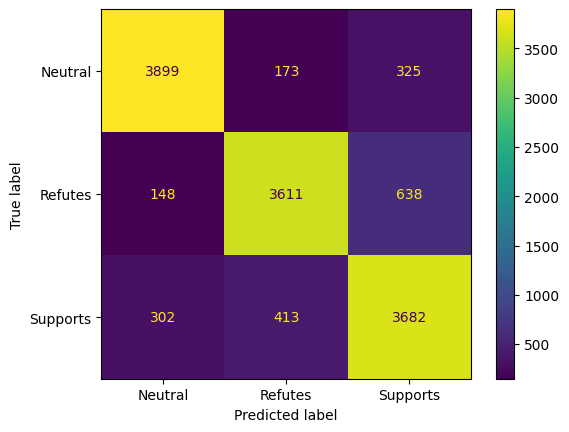

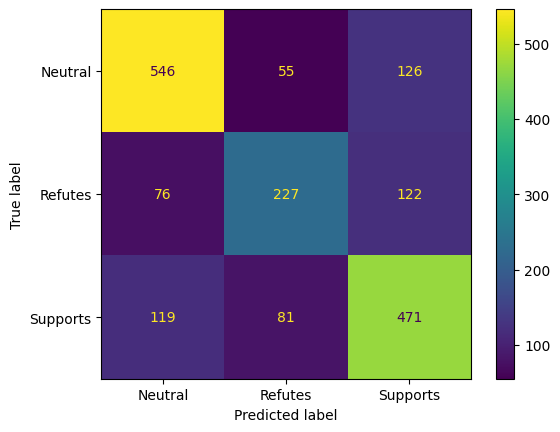

In [96]:
train_pred, train_true = maskedval_train_predictions, maskedval_train_labels
test_pred, test_true = maskedval_test_predictions,maskedval_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

In [46]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [32]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_masked_model_train')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-masked-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
masked_model_train = BERTClassifier(3)
trainer.fit(masked_model_train, train_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | dropout    | Dropout   | 0     
2 | cl

Epoch 0:   0%|                                                                                  | 0/407 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 407/407 [03:37<00:00,  1.87it/s, loss=0.478, v_num=1]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 407/407 [03:38<00:00,  1.86it/s, loss=0.0272, v_num=1]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 407/407 [03:38<00:00,  1.86it/s, loss=0.0272, v_num=1]


In [47]:
#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
masked_best_model_train = BERTClassifier.load_from_checkpoint('Models/scibert_best_model-masked-epoch=12-train_loss=0.0204.ckpt' ,num_classes=3)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
masked_best_model_train.to(device) 
masked_train_predictions, masked_train_labels, _ = evaluate_model(masked_best_model_train, train_data_loader)
masked_test_predictions,masked_test_labels, _ = evaluate_model(masked_best_model_train, test_data_loader)

              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00      4400
     Refutes       1.00      1.00      1.00      4815
    Supports       1.00      1.00      1.00      3786

    accuracy                           1.00     13001
   macro avg       1.00      1.00      1.00     13001
weighted avg       1.00      1.00      1.00     13001

              precision    recall  f1-score   support

     Neutral       0.83      0.80      0.81       760
     Refutes       0.63      0.70      0.67       381
    Supports       0.76      0.75      0.76       682

    accuracy                           0.76      1823
   macro avg       0.74      0.75      0.75      1823
weighted avg       0.76      0.76      0.76      1823



              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00      4397
     Refutes       1.00      1.00      1.00      4822
    Supports       1.00      1.00      1.00      3782

    accuracy                           1.00     13001
   macro avg       1.00      1.00      1.00     13001
weighted avg       1.00      1.00      1.00     13001


              precision    recall  f1-score   support

     Neutral       0.80      0.83      0.81       727
     Refutes       0.70      0.63      0.67       425
    Supports       0.75      0.76      0.76       671

    accuracy                           0.76      1823
   macro avg       0.75      0.74      0.75      1823
weighted avg       0.76      0.76      0.76      1823

[[4392    3    2]
 [   6 4810    6]
 [   2    2 3778]]

[[605  34  88]
 [ 75 268  82]
 [ 80  79 512]]


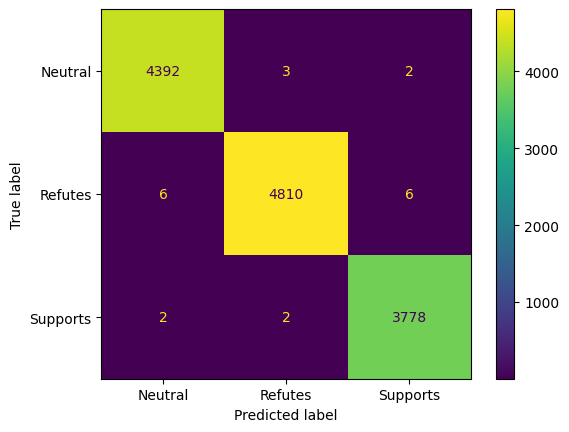

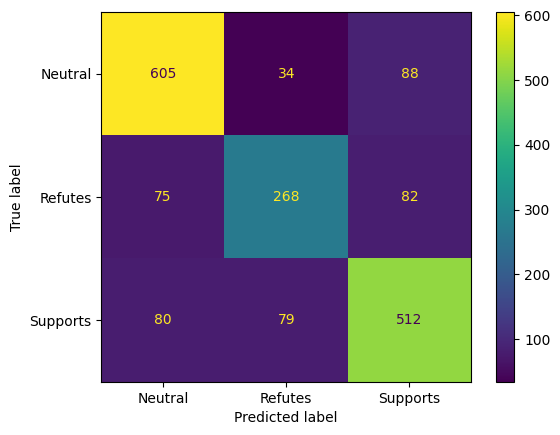

In [94]:
train_pred, train_true = masked_train_predictions, masked_train_labels
test_pred, test_true = masked_test_predictions,masked_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

In [ ]:
masked_test_predictions,masked_test_labels, _ = evaluate_model(best_model, test_data_loader)
print(classification_report(masked_test_predictions, masked_test_labels, target_names = target_names))

# Oversampling

In [70]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [71]:
y = train_df['label']
X = train_df.drop('label', axis=1)

In [72]:
oversample = RandomOverSampler(sampling_strategy='all')
X_over, y_over = oversample.fit_resample(X, y)

X_over['label'] = y_over
train_df_random_oversampled = X_over

In [73]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_claims = train_df_random_oversampled['claim'].values
train_evidences = train_df_random_oversampled['evidence'].values
train_labels = train_df_random_oversampled['label'].values
train_topic_ips = train_df_random_oversampled['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_df['claim'].values
val_evidences = val_df['evidence'].values
val_labels = val_df['label'].values
val_topic_ips = val_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)

In [74]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)


In [32]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_oversampled_model')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-oversampled_model-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
oversampled_model = BERTClassifier(3)
trainer.fit(oversampled_model, train_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_oversampled_model
Missing logger folder: ./logs/scibert_oversampled_model
Missing logger folder: ./logs/scibert_oversampled_model
Missing logger folder: ./logs/scibert_oversampled_model
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
----

Epoch 0:   0%|                                                                                  | 0/413 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 413/413 [03:41<00:00,  1.86it/s, loss=0.527, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 413/413 [03:42<00:00,  1.86it/s, loss=0.0651, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 413/413 [03:42<00:00,  1.86it/s, loss=0.0651, v_num=0]


In [75]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
oversampled_model = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-oversampled_model-epoch=12-train_loss=0.0285.ckpt',num_classes=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
oversampled_model.to(device) 
oversampled_train_predictions, oversampled_train_labels, _ = evaluate_model(oversampled_model, train_data_loader)
oversampled_test_predictions, oversampled_test_labels, _ = evaluate_model(oversampled_model, test_data_loader)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

     Neutral       0.99      1.00      0.99      4397
     Refutes       1.00      0.99      1.00      4397
    Supports       1.00      1.00      1.00      4397

    accuracy                           1.00     13191
   macro avg       1.00      1.00      1.00     13191
weighted avg       1.00      1.00      1.00     13191


              precision    recall  f1-score   support

     Neutral       0.74      0.86      0.79       727
     Refutes       0.81      0.55      0.66       425
    Supports       0.73      0.76      0.75       671

    accuracy                           0.75      1823
   macro avg       0.76      0.72      0.73      1823
weighted avg       0.75      0.75      0.74      1823

[[4394    1    2]
 [  30 4358    9]
 [  20    0 4377]]

[[622  22  83]
 [ 89 235 101]
 [128  34 509]]


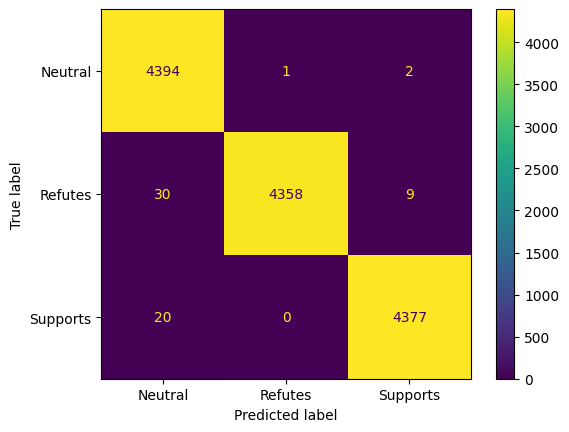

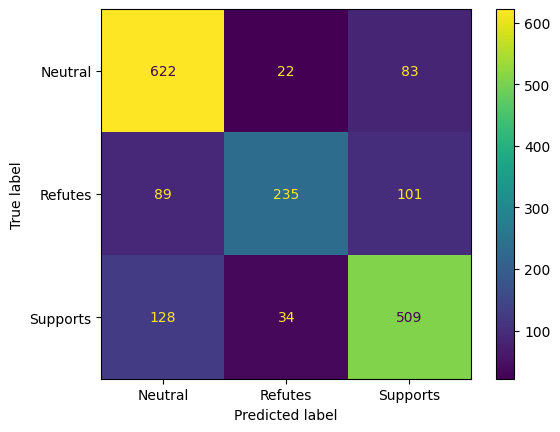

In [97]:
train_pred, train_true = oversampled_train_predictions, oversampled_train_labels
test_pred, test_true = oversampled_test_predictions,oversampled_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

In [15]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_oversampled_model_val')
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-oversampled_model_val-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
oversampled_model_val = BERTClassifier(3)
trainer.fit(oversampled_model_val, train_data_loader, val_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_oversampled_model_val
Missing logger folder: ./logs/scibert_oversampled_model_val
Missing logger folder: ./logs/scibert_oversampled_model_val
Missing logger folder: ./logs/scibert_oversampled_model_val
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type   

Sanity Checking: 0it [00:00, ?it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:218: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  "strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks."


Sanity Checking DataLoader 0: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.82it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 0:   0%|                                                                                  | 0/473 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 473/473 [03:51<00:00,  2.04it/s, loss=0.486, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|████████████████████████████████████████████████| 473/473 [03:50<00:00,  2.05it/s, loss=0.00834, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████████████| 473/473 [03:51<00:00,  2.05it/s, loss=0.00834, v_num=0]
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [76]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
oversampled_val_model = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-oversampled_model_val-epoch=00-val_loss=0.7404.ckpt',num_classes=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
oversampled_val_model.to(device) 
oversampled_val_train_predictions32, oversampled_val_train_labels32, _ = evaluate_model(oversampled_val_model, train_data_loader)
oversampled_val_test_predictions32,oversampled_val_test_labels32, _ = evaluate_model(oversampled_val_model, test_data_loader)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

     Neutral       0.92      0.89      0.90      4397
     Refutes       0.81      0.84      0.82      4397
    Supports       0.82      0.81      0.82      4397

    accuracy                           0.85     13191
   macro avg       0.85      0.85      0.85     13191
weighted avg       0.85      0.85      0.85     13191


              precision    recall  f1-score   support

     Neutral       0.78      0.78      0.78       727
     Refutes       0.53      0.61      0.57       425
    Supports       0.70      0.63      0.66       671

    accuracy                           0.68      1823
   macro avg       0.67      0.67      0.67      1823
weighted avg       0.69      0.68      0.69      1823

[[3919  240  238]
 [ 157 3688  552]
 [ 192  625 3580]]

[[565  82  80]
 [ 66 260  99]
 [ 97 151 423]]


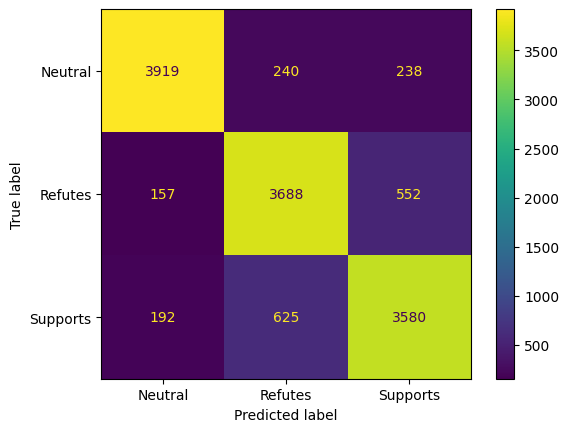

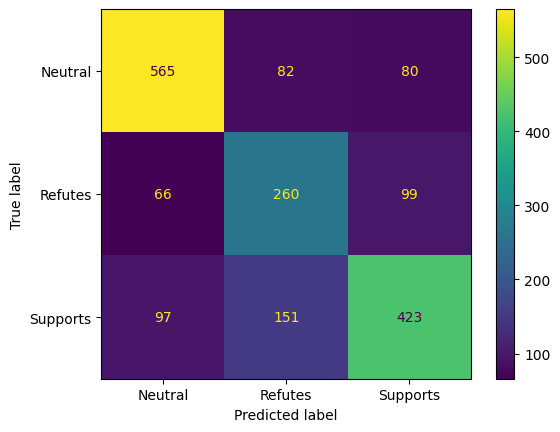

In [98]:
train_pred, train_true = oversampled_val_train_predictions32, oversampled_val_train_labels32
test_pred, test_true = oversampled_val_test_predictions32,oversampled_val_test_labels32
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# Undersampling

In [56]:
undersampler = RandomUnderSampler(sampling_strategy='all')
X_under, y_under = undersampler.fit_resample(X, y)

X_under['label'] = y_under
train_df_random_undersampled = X_under

In [57]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_claims = train_df_random_undersampled['claim'].values
train_evidences = train_df_random_undersampled['evidence'].values
train_labels = train_df_random_undersampled['label'].values
train_topic_ips = train_df_random_undersampled['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

val_claims = val_df['claim'].values
val_evidences = val_df['evidence'].values
val_labels = val_df['label'].values
val_topic_ips = val_df['topic_ip'].values
val_labels = label_encoder.transform(val_labels)

In [58]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [35]:
#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_undersampled_model')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-undersampled_model-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
undersampled_model = BERTClassifier(3)
trainer.fit(undersampled_model, train_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_undersampled_model
Missing logger folder: ./logs/scibert_undersampled_model
Missing logger folder: ./logs/scibert_undersampled_model
Missing logger folder: ./logs/scibert_undersampled_model
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params


Epoch 0:   0%|                                                                                  | 0/227 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 227/227 [02:01<00:00,  1.86it/s, loss=0.886, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 227/227 [02:01<00:00,  1.87it/s, loss=0.0372, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 227/227 [02:01<00:00,  1.87it/s, loss=0.0372, v_num=0]


In [64]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
undersampled_model = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-undersampled_model-epoch=11-train_loss=0.0370.ckpt',num_classes=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
undersampled_model.to(device) 
undersampled_train_predictions, undersampled_train_labels, _ = evaluate_model(undersampled_model, train_data_loader)
undersampled_test_predictions,undersampled_test_labels, _ = evaluate_model(undersampled_model, test_data_loader)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

     Neutral       0.97      0.97      0.97      4397
     Refutes       0.97      0.98      0.97      4397
    Supports       0.97      0.96      0.97      4397

    accuracy                           0.97     13191
   macro avg       0.97      0.97      0.97     13191
weighted avg       0.97      0.97      0.97     13191


              precision    recall  f1-score   support

     Neutral       0.77      0.85      0.81       727
     Refutes       0.70      0.55      0.61       425
    Supports       0.73      0.74      0.73       671

    accuracy                           0.74      1823
   macro avg       0.73      0.71      0.72      1823
weighted avg       0.74      0.74      0.73      1823

[[4251   72   74]
 [  38 4310   49]
 [  95   70 4232]]

[[618  32  77]
 [ 82 232 111]
 [107  66 498]]


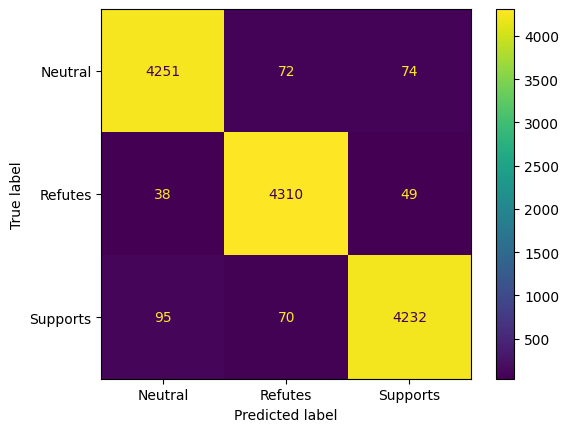

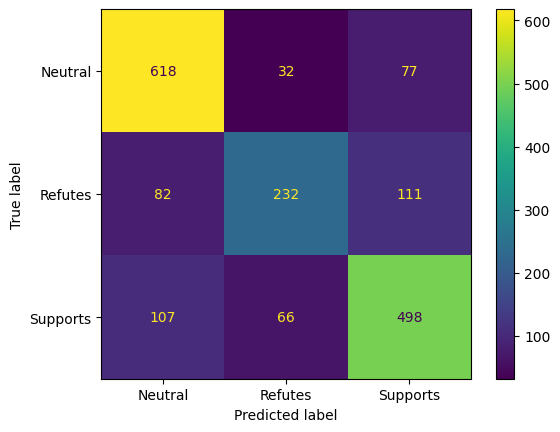

In [99]:
train_pred, train_true = undersampled_train_predictions, undersampled_train_labels
test_pred, test_true = undersampled_test_predictions,undersampled_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

In [36]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_undersampled_model_val')
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-undersampled_model_val-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
undersampled_model_val = BERTClassifier(3)
trainer.fit(undersampled_model_val, train_data_loader, val_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_undersampled_model_val
Missing logger folder: ./logs/scibert_undersampled_model_val
Missing logger folder: ./logs/scibert_undersampled_model_val
Missing logger folder: ./logs/scibert_undersampled_model_val
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Typ

Sanity Checking: 0it [00:00, ?it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:218: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  "strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks."


Sanity Checking DataLoader 0: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.90it/s]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 0:   0%|                                                                                  | 0/287 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 287/287 [02:11<00:00,  2.18it/s, loss=0.888, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 287/287 [02:11<00:00,  2.19it/s, loss=0.0249, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 287/287 [02:11<00:00,  2.18it/s, loss=0.0249, v_num=0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [65]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
undersampled_val_model = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-undersampled_model_val-epoch=00-val_loss=0.7891.ckpt',num_classes=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
undersampled_val_model.to(device) 
undersampled_val_train_predictions, undersampled_val_train_labels, _ = evaluate_model(undersampled_val_model, train_data_loader)
undersampled_val_test_predictions,undersampled_val_test_labels, _ = evaluate_model(undersampled_val_model, test_data_loader)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

     Neutral       0.77      0.76      0.76      4397
     Refutes       0.62      0.74      0.67      4397
    Supports       0.63      0.52      0.57      4397

    accuracy                           0.67     13191
   macro avg       0.67      0.67      0.67     13191
weighted avg       0.67      0.67      0.67     13191


              precision    recall  f1-score   support

     Neutral       0.72      0.69      0.70       727
     Refutes       0.42      0.70      0.53       425
    Supports       0.54      0.35      0.42       671

    accuracy                           0.57      1823
   macro avg       0.56      0.58      0.55      1823
weighted avg       0.59      0.57      0.56      1823

[[3321  492  584]
 [ 384 3257  756]
 [ 586 1533 2278]]

[[501 113 113]
 [ 47 296  82]
 [147 291 233]]


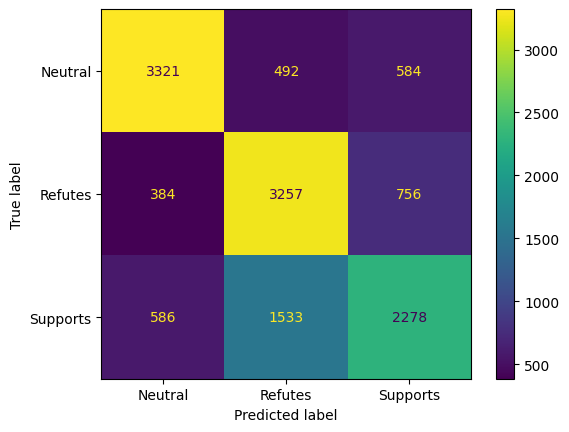

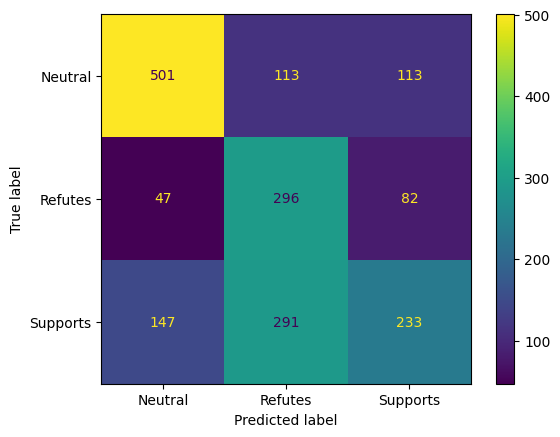

In [100]:
train_pred, train_true = undersampled_val_train_predictions, undersampled_val_train_labels
test_pred, test_true = undersampled_val_test_predictions,undersampled_val_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)

# Cross Validation

In [66]:
train_val_df = pd.concat((train_df, val_df))
train_val_df.reset_index(drop=True)

,id,evidence,claim,label,topic_ip,question
0,2868,HCQ should be prescribed as a part of treatmen...,Results on the use of hydroxychloroquine as a ...,Refutes,28,does hydroxychloroquine treat COVID-19?
1,6321,"As discussed in this review, till effective va...",The good news. Properly disinfecting our homes...,Neutral,60,Can vinegar help in preventing COVID-19?
2,4393,"Model simulations, using data relevant to COVI...","If you decide to engage in public activities, ...",Supports,44,How much impact do masks have on preventing th...
3,1631,Respiratory failure has been cited as the majo...,Blood clotting a significant cause of death in...,Refutes,4,how do people die from the coronavirus?
4,9893,Surgical mask partition reduces the risk of no...,But until we understand more about who is a ca...,Supports,125,Does a surgical mask help avoid COVID-19?
...,...,...,...,...,...,...
12502,12518,The CD4 + memory exploiting could help immune ...,Long-term health conditions and aging weaken y...,Neutral,3,will SARS-CoV2 infected people develop immunity?
12503,7662,There are clearly COVID-19 cases where NSAIDs ...,Is it safe to take acetaminophen/Tylenol to tr...,Supports,69,"Can taking medication to lower fever, such as ..."
12504,9643,We conducted a retrospective analysis of child...,"Yes, kids can get COVID-19",Supports,116,Can children get COVID-19?
12505,12620,Distinguishing pre-existing and de novo antibo...,"Early symptoms for covid-19: include fever, co...",Neutral,3,will SARS-CoV2 infected people develop immunity?


In [67]:
label_encoder = LabelEncoder()

train_claims = train_val_df['claim'].values
train_evidences = train_val_df['evidence'].values
train_labels = train_val_df['label'].values
train_topic_ips = train_val_df['topic_ip'].values
train_labels = label_encoder.fit_transform(train_labels)

test_claims = test_df['claim'].values
test_evidences = test_df['evidence'].values
test_labels = test_df['label'].values
test_topic_ips = test_df['topic_ip'].values
test_labels = label_encoder.transform(test_labels)

In [68]:
batch_size = 8

train_dataset = TextClassificationDataset(train_claims, train_evidences, train_labels, tokenizer, max_length_claim, max_length_evidence)
test_dataset = TextClassificationDataset(test_claims, test_evidences, test_labels, tokenizer, max_length_claim, max_length_evidence)
val_dataset = TextClassificationDataset(val_claims, val_evidences, val_labels, tokenizer, max_length_claim, max_length_evidence)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [39]:

#{epoch:02d}-{train_loss:.4f}
tensorboard_logger = TensorBoardLogger(save_dir='./logs', name='scibert_cross_val_model')
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath='./Models/',
    filename='scibert_best_model-cross_val-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,  # Save only the best model
)
trainer = pl.Trainer(
    gpus=4, 
    max_epochs=15,
    logger = tensorboard_logger,
    callbacks=[checkpoint_callback]
)

# Initialize the Trainer with EarlyStopping callback
cross_val_model = BERTClassifier(3)
trainer.fit(cross_val_model, train_data_loader)

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=4)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=4)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: ./logs/scibert_cross_val_model
Missing logger folder: ./logs/scibert_cross_val_model
Missing logger folder: ./logs/scibert_cross_val_model
Missing logger folder: ./logs/scibert_cross_val_model
/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/tanwa/Models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params
------------

Epoch 0:   0%|                                                                                  | 0/391 [00:00<?, ?it/s]

[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1289] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0: 100%|███████████████████████████████████████████████████| 391/391 [03:30<00:00,  1.86it/s, loss=0.493, v_num=0]

/home/tanwa/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:543: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Epoch 14: 100%|█████████████████████████████████████████████████| 391/391 [03:31<00:00,  1.85it/s, loss=0.0775, v_num=0]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████████████| 391/391 [03:35<00:00,  1.82it/s, loss=0.0775, v_num=0]


In [69]:

#best_model_checkpoint = os.path.join(checkpoint_callback.best_model_path, f"best_model-{checkpoint_callback.best_model_score:.4f}.ckpt")
crossval_model = BERTClassifier.load_from_checkpoint('./Models/scibert_best_model-cross_val-epoch=14-train_loss=0.0333.ckpt',num_classes=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
crossval_model.to(device) 
crossval_train_predictions, crossval_train_labels, _ = evaluate_model(crossval_model, train_data_loader)
crossval_test_predictions,crossval_test_labels, _ = evaluate_model(crossval_model, test_data_loader)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00      5390
     Refutes       1.00      1.00      1.00      2802
    Supports       1.00      1.00      1.00      4315

    accuracy                           1.00     12507
   macro avg       1.00      1.00      1.00     12507
weighted avg       1.00      1.00      1.00     12507


              precision    recall  f1-score   support

     Neutral       0.78      0.83      0.80       727
     Refutes       0.70      0.64      0.67       425
    Supports       0.77      0.76      0.77       671

    accuracy                           0.76      1823
   macro avg       0.75      0.74      0.75      1823
weighted avg       0.76      0.76      0.76      1823

[[5378    1   11]
 [   1 2795    6]
 [   2    4 4309]]

[[602  44  81]
 [ 84 270  71]
 [ 86  72 513]]


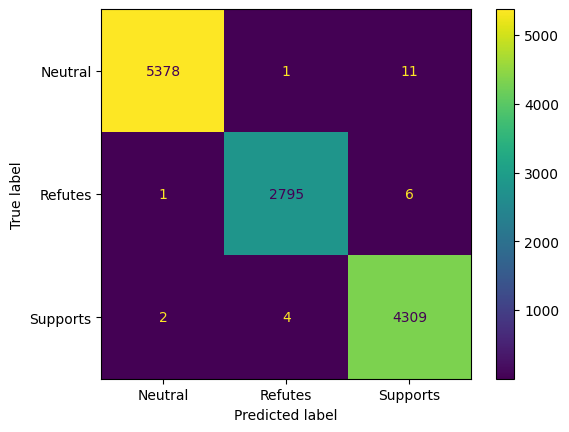

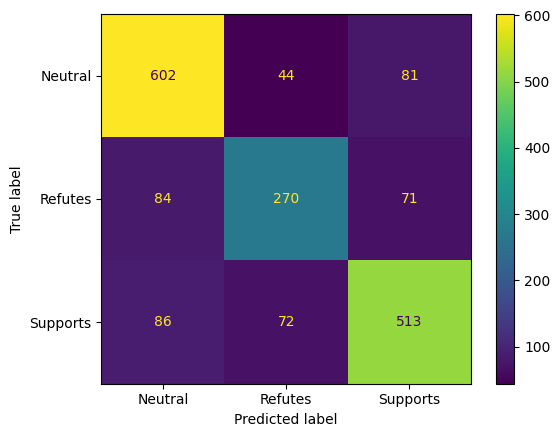

In [101]:
train_pred, train_true = crossval_train_predictions, crossval_train_labels
test_pred, test_true = crossval_test_predictions,crossval_test_labels
print(classification_report(train_true, train_pred, target_names = target_names))
print()
print(classification_report(test_true, test_pred, target_names = target_names))
print(confusion_matrix(train_true, train_pred))
print()
print(confusion_matrix(test_true, test_pred))

ConfusionMatrixDisplay.from_predictions(train_true, train_pred, display_labels=target_names)
ConfusionMatrixDisplay.from_predictions(test_true, test_pred, display_labels=target_names)